In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

In [2]:
pedestals=pd.read_csv("pedestals.csv", sep=',')
pedestals=pedestals.drop(columns=['pedestal_per_time_sample', 'std_dev', 'mean'])

In [3]:
mips=pd.read_csv("mip.csv", sep=',')
mips=mips.drop(columns=['eta', 'sigma', 'A'])

In [4]:
def choose_bar(df,layer, strip):
    df=df[df["strip"]==strip]
    df=df[df["layer"]==layer]
    return df

In [5]:
def choose_layer(df,layer):
    df=df[df['layer']==layer]
    return df

In [6]:
def drop_empty(df):
    events=[]
    adc_0=[]
    adc_1=[]
    l=[]
    s=[]
    data=[]

    layers=np.arange(1,20)
    strips=np.arange(0,12)
    
    for layer in layers:
        for strip in strips:
            el=choose_bar(df,layer,strip)
            peds=choose_bar(pedestals,layer,strip)
            mip=choose_bar(mips, layer, strip)

            if not peds.empty: # need to check whether the strip exists 
                el=el[el["adc_sum_end0"]>1.2*peds.iloc[0,-1]] # gets rid of bars where there's no data in end0
                el=el[el["adc_sum_end1"]>1.2*peds.iloc[1,-1]] # gets rid of bars where there's no data in end1
                
                el.loc[:,"adc_sum_end0"]-=peds.iloc[0,-1] # subtracting pedestals
                el.loc[:,"adc_sum_end1"]-=peds.iloc[1,-1]
                
                el.loc[:,"adc_sum_end0"]*=(4.66/mip.iloc[0,-1]) # converting to energy
                el.loc[:,"adc_sum_end1"]*=(4.66/mip.iloc[1,-1])
                
                data.extend(el.values.tolist())
    
    df_s=pd.DataFrame(data, columns=['event', 'adc_sum_end0', 'layer', 'strip', 'adc_sum_end1'])
    
    return df_s

In [7]:
def get_event(df, event):
    df=df[df["event"]==event]
    return df

In [8]:
def drop_nonelectron(df, bl_num):
    events=df.event.unique()
    
    # check first layer
    for event in tqdm(events):
        el=get_event(df, event)
        el_1=choose_layer(el, 1)
        if el_1.shape[0]>1:
            df=df[df.event!=event]
    
    # check bl_num number of back layers
        else:
            el_i=el[el['layer']>=20-bl_num]
            if el_i.shape[0]:
                df=df[df.event!=event]
            
    return df

In [98]:
electron=pd.read_csv("run_300.csv", sep=',')
electron=electron.drop(columns=['tot_end0', 'toa_end0','tot_end1', 'toa_end1', 'adc_max_end0', 'adc_max_end1',
                                'pf_spill', 'adc_mean_end0', 'adc_mean_end1', 'pf_ticks'])

electron=electron.astype({"adc_sum_end0":float,"adc_sum_end1":float}) 

In [99]:
electron=drop_empty(electron)

In [100]:
electron=drop_nonelectron(electron,7)

100%|████████████████████████████████████████████████████████████████████████████| 71414/71414 [35:59<00:00, 33.07it/s]


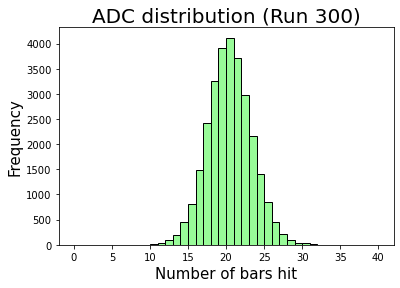

In [120]:
adc_by_event=electron.groupby(['event']).count().drop(columns=["layer", "strip"]).reset_index()
plt.rcParams["figure.figsize"]=(6,4)
plt.hist(adc_by_event["adc_sum_end0"],range=(0,40), bins=40, color="palegreen", edgecolor="black")
plt.ylabel("Frequency", fontsize=15)
plt.xlabel("Number of bars hit", fontsize=15)
plt.title("ADC distribution (Run 300)", fontsize=20)
plt.savefig("run_300_adc_dist.png", bbox_inches='tight')
plt.show()

In [121]:
events=electron.event.unique()
shares=np.zeros(40)
for event in tqdm(events):
    single=get_event(electron, event)
    sum_adc=(sum(single["adc_sum_end0"])+sum(single["adc_sum_end1"]))/2
    adcs=np.sort((np.array(single["adc_sum_end0"])+np.array(single["adc_sum_end1"]))/2)[::-1]
    l=40-len(adcs)
    adcs=np.append(adcs,np.zeros(l))
    shares=np.add(shares, adcs)
shares=np.divide(shares, len(events))

100%|███████████████████████████████████████████████████████████████████████████| 28741/28741 [00:42<00:00, 676.15it/s]


In [125]:
s=sum(shares[10:])
short_shares=shares[:10]
short_shares=np.append(short_shares,s)

In [131]:
colors=['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f',
        '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#f0027f']
labels=["1st", "2nd", "3rd", "4th","5th", "6th","7th", "8th", "9th", "10th", "Rest"]

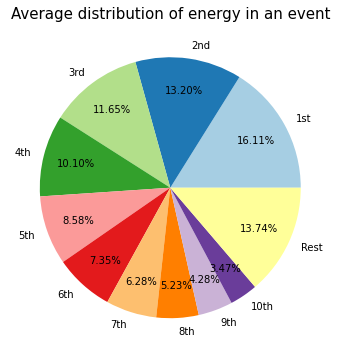

In [133]:
plt.rcParams["figure.figsize"]=(9,6)
plt.pie(short_shares, colors=colors, labels=labels, autopct='%1.2f%%', pctdistance=0.75)
plt.title("Average distribution of energy in an event", fontsize=15)
plt.savefig("plots/run_300_average_piechart.png")
plt.show()